IMPORT LIBRARIES

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


DIRECTORIES

In [3]:
train_dir = "./DATASET/chest_xray/train"
val_dir = "./DATASET/chest_xray/val"
test_dir = "./DATASET/chest_xray/test"

import os

for path in [train_dir, val_dir, test_dir]:
    print(path, "→", "✅ Found" if os.path.exists(path) else "❌ Not Found")



./DATASET/chest_xray/train → ✅ Found
./DATASET/chest_xray/val → ✅ Found
./DATASET/chest_xray/test → ✅ Found


CHECK CLASS DISTRIBUTION

In [ ]:
for folder in ["NORMAL", "PNEUMONIA"]:
    n_images = len(os.listdir(os.path.join(train_dir, folder)))
    print(f"{folder}: {n_images} images")

NORMAL: 1341 images
PNEUMONIA: 3875 images


REDUCE THE DATASET TO MATCH FEATURES BY UNDERSAMPLING THE MAJORITY CLASS INSTEAD OF AUGMENTATIONS

In [6]:
import os
import random
import shutil

# --- CONFIG ---
base_path = "./DATASET/chest_xray"
splits = ["train", "val", "test"]  # we'll balance all 3 splits
balanced_base = "./DATASET/chest_xray_balanced"

# Create new root folder
os.makedirs(balanced_base, exist_ok=True)

for split in splits:
    print(f"\n⚙️ Balancing split: {split.upper()}")
    src_split_dir = os.path.join(base_path, split)
    dst_split_dir = os.path.join(balanced_base, split)

    # Paths for classes
    normal_src = os.path.join(src_split_dir, "NORMAL")
    pneumonia_src = os.path.join(src_split_dir, "PNEUMONIA")
    normal_dst = os.path.join(dst_split_dir, "NORMAL")
    pneumonia_dst = os.path.join(dst_split_dir, "PNEUMONIA")

    # Create destination dirs
    os.makedirs(normal_dst, exist_ok=True)
    os.makedirs(pneumonia_dst, exist_ok=True)

    # List files
    normal_imgs = os.listdir(normal_src)
    pneumonia_imgs = os.listdir(pneumonia_src)

    n_normal = len(normal_imgs)
    n_pneumonia = len(pneumonia_imgs)
    print(f"  NORMAL: {n_normal}, PNEUMONIA: {n_pneumonia}")

    # Choose how many pneumonia images to keep (match NORMAL)
    n_keep = min(n_normal, n_pneumonia)

    # If PNEUMONIA > NORMAL, randomly select
    if n_pneumonia > n_keep:
        pneumonia_imgs = random.sample(pneumonia_imgs, n_keep)
        print(f"  🔻 Undersampling PNEUMONIA → {n_keep}")
    elif n_normal > n_keep:
        normal_imgs = random.sample(normal_imgs, n_keep)
        print(f"  🔻 Undersampling NORMAL → {n_keep}")

    # Copy images
    for img in normal_imgs:
        shutil.copy(os.path.join(normal_src, img), os.path.join(normal_dst, img))
    for img in pneumonia_imgs:
        shutil.copy(os.path.join(pneumonia_src, img), os.path.join(pneumonia_dst, img))

    print(f"✅ Balanced {split} created: {n_keep} per class")

print("\n🎉 All splits balanced successfully!")
print(f"📂 New dataset: {balanced_base}")


⚙️ Balancing split: TRAIN
  NORMAL: 1341, PNEUMONIA: 3875
  🔻 Undersampling PNEUMONIA → 1341
✅ Balanced train created: 1341 per class

⚙️ Balancing split: VAL
  NORMAL: 8, PNEUMONIA: 8
✅ Balanced val created: 8 per class

⚙️ Balancing split: TEST
  NORMAL: 234, PNEUMONIA: 390
  🔻 Undersampling PNEUMONIA → 234
✅ Balanced test created: 234 per class

🎉 All splits balanced successfully!
📂 New dataset: ./DATASET/chest_xray_balanced


NOW DO AUGMENTATION SO AS TO GET BALANCED SATASET AND DIFFERNT VARIETY OF ANGLES OF PNEUMONIC IMAGE

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Augment only training data to increase diversity
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,         # small rotations
    width_shift_range=0.1,     # slight horizontal shift
    height_shift_range=0.1,    # slight vertical shift
    zoom_range=0.1,            # slight zoom in/out
    horizontal_flip=True,      # flip for symmetry
    brightness_range=[0.8, 1.2], # simulate exposure variation
    fill_mode='nearest'
)

# ✅ Validation & Test sets — no augmentation, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
train_dir = "./DATASET/chest_xray_balanced/train"
val_dir = "./DATASET/chest_xray_balanced/val"
test_dir = "./DATASET/chest_xray_balanced/test"


In [9]:
batch_size = 32
img_size = (224, 224)  # Common input size for models like VGG, ResNet, etc.

train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 2682 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 468 images belonging to 2 classes.


AUGMENTED IMAGE (DIFFERNT AUGMENTED IMAGE CAN BE SEEN OF ORIGINAL IMAGE EACH TIME YOU RERUN)

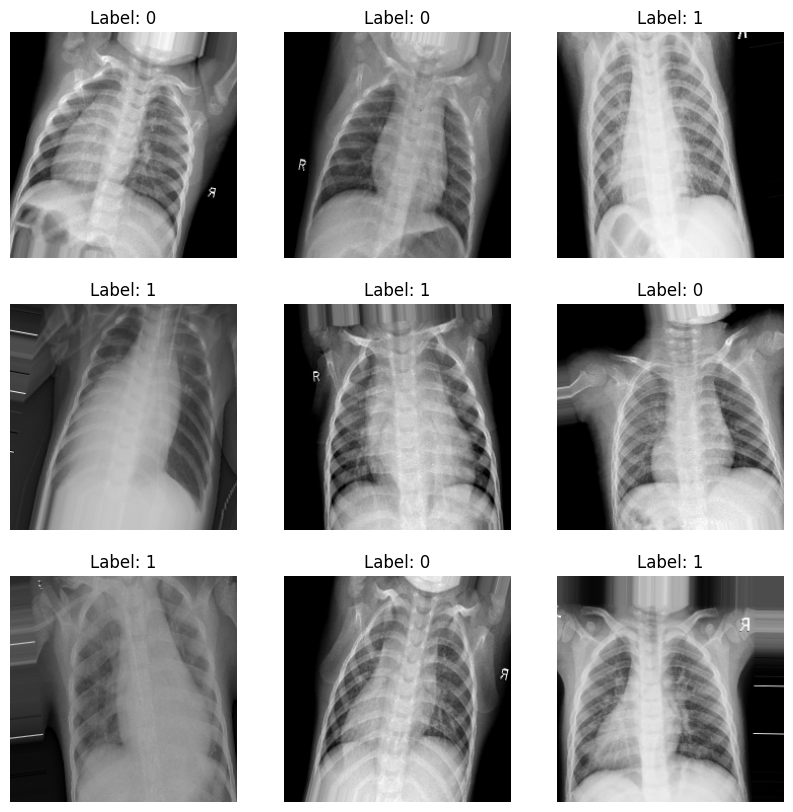

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis("off")
plt.show()


Bar Chart for Dataset Distribution

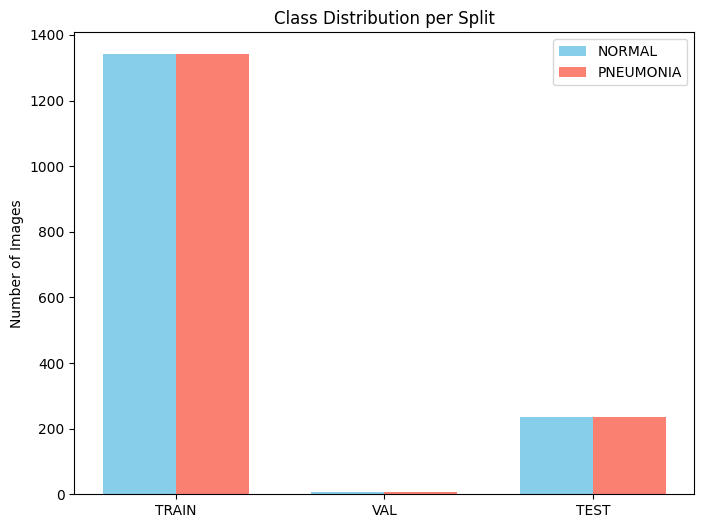

In [12]:
import os
import matplotlib.pyplot as plt

# Paths to your balanced dataset
base_dir = "./DATASET/chest_xray_balanced"
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Collect counts
counts = {split: [] for split in splits}

for split in splits:
    for cls in classes:
        cls_path = os.path.join(base_dir, split, cls)
        n_imgs = len(os.listdir(cls_path))
        counts[split].append(n_imgs)

# Plot
x = range(len(splits))
width = 0.35  # bar width

plt.figure(figsize=(8,6))
plt.bar([p - width/2 for p in x], [counts[split][0] for split in splits], width=width, label="NORMAL", color='skyblue')
plt.bar([p + width/2 for p in x], [counts[split][1] for split in splits], width=width, label="PNEUMONIA", color='salmon')

plt.xticks(x, [split.upper() for split in splits])
plt.ylabel("Number of Images")
plt.title("Class Distribution per Split")
plt.legend()
plt.show()


Visualize Dataset Split

📊 Dataset distribution:

Split: TRAIN
  NORMAL: 1341 images
  PNEUMONIA: 1341 images

Split: VAL
  NORMAL: 8 images
  PNEUMONIA: 8 images

Split: TEST
  NORMAL: 234 images
  PNEUMONIA: 234 images


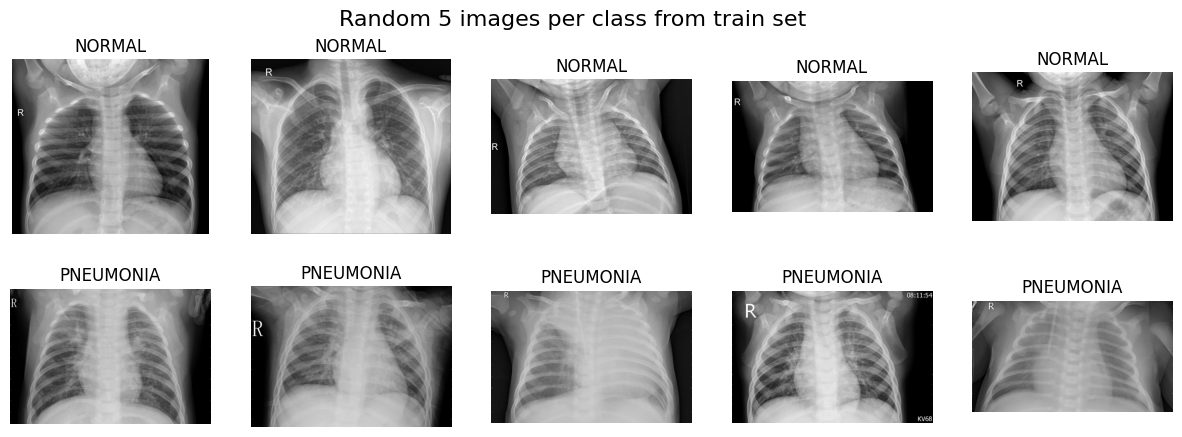

In [13]:
import os
import matplotlib.pyplot as plt
import random
from matplotlib.image import imread

# Paths to your balanced dataset
base_dir = "./DATASET/chest_xray_balanced"
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# 1️⃣ Show number of images per split & class
print("📊 Dataset distribution:")
for split in splits:
    print(f"\nSplit: {split.upper()}")
    for cls in classes:
        cls_path = os.path.join(base_dir, split, cls)
        n_imgs = len(os.listdir(cls_path))
        print(f"  {cls}: {n_imgs} images")

# 2️⃣ Visualize a few random images per class from train
def show_random_images(split="train", num_images=5):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(base_dir, split, cls)
        imgs = os.listdir(cls_path)
        sample_imgs = random.sample(imgs, num_images)
        for j, img_name in enumerate(sample_imgs):
            img_path = os.path.join(cls_path, img_name)
            img = imread(img_path)
            plt.subplot(len(classes), num_images, i*num_images + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{cls}")
            plt.axis('off')
    plt.suptitle(f"Random {num_images} images per class from {split} set", fontsize=16)
    plt.show()

# Show 5 random images per class from training set
show_random_images("train", 5)

# Optional: also show for val/test
# show_random_images("val", 3)
# show_random_images("test", 5)


NOW APPLYING DIFFERNT ALGORITHMS FOR EVALUATING BEST MODELS

BUILD DENSE NET MODEL

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [15]:
# Load DenseNet121 pretrained on ImageNet, exclude top
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

TRAINING

In [16]:
epochs = 20  # you can increase to 20-30 for better results

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)


c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7338 - loss: 0.5107 - val_accuracy: 0.8125 - val_loss: 0.3873
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 968ms/step - accuracy: 0.8762 - loss: 0.3155 - val_accuracy: 0.8750 - val_loss: 0.3404
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 993ms/step - accuracy: 0.8993 - loss: 0.2692 - val_accuracy: 0.8750 - val_loss: 0.3207
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9098 - loss: 0.2451 - val_accuracy: 0.8750 - val_loss: 0.2940
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9113 - loss: 0.2312 - val_accuracy: 0.8125 - val_loss: 0.3064
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 959ms/step - accuracy: 0.9195 - loss: 0.2204 - val_accuracy: 0.8750 - val_loss: 0.2731
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 974ms/step - accuracy: 0.9228 - loss: 0.2164 - val_accuracy: 0.9375 - val_loss: 0.2732
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9254 - loss: 0.2021 - val_accuracy: 0.93

EVALUATION ON TEST SET

In [17]:
# 1️⃣ Evaluate loss & accuracy
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# 2️⃣ Predictions
test_gen.reset()
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)

# 3️⃣ True labels
y_true = test_gen.classes

# 4️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# 5️⃣ Classification Report
cr = classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA'])
print("Classification Report:\n", cr)

# 6️⃣ ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1000ms/step - accuracy: 0.8803 - loss: 0.2818
Test Accuracy: 88.03%
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 937ms/step
Confusion Matrix:
 [[201  33]
 [ 23 211]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.90      0.86      0.88       234
   PNEUMONIA       0.86      0.90      0.88       234

    accuracy                           0.88       468
   macro avg       0.88      0.88      0.88       468
weighted avg       0.88      0.88      0.88       468

ROC-AUC: 0.9543


In [18]:
# Training accuracy per epoch
train_acc = history.history['accuracy']
print("Training accuracy per epoch:", train_acc)

# Validation accuracy per epoch
val_acc = history.history['val_accuracy']
print("Validation accuracy per epoch:", val_acc)


Training accuracy per epoch: [0.7337807416915894, 0.8762117624282837, 0.899328887462616, 0.90976881980896, 0.9112602472305298, 0.9194630980491638, 0.9228187799453735, 0.9254288077354431, 0.9328858852386475, 0.9295302033424377, 0.9302759170532227, 0.9295302033424377, 0.9310216307640076, 0.9358687400817871, 0.9399701952934265, 0.9351230263710022, 0.9351230263710022, 0.935495913028717, 0.9381058812141418, 0.9384787678718567]
Validation accuracy per epoch: [0.8125, 0.875, 0.875, 0.875, 0.8125, 0.875, 0.9375, 0.9375, 0.875, 0.9375, 0.875, 0.9375, 0.875, 0.9375, 0.875, 0.875, 1.0, 1.0, 0.9375, 0.875]


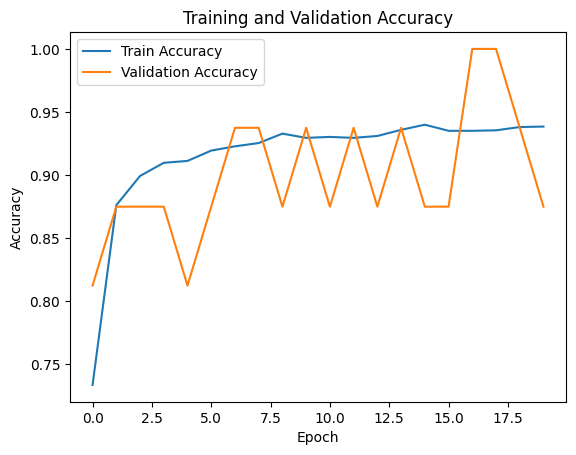

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [20]:
loss, acc = model.evaluate(train_gen)
print(f"Final training accuracy: {acc*100:.2f}%")


84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 962ms/step - accuracy: 0.9500 - loss: 0.1411
Final training accuracy: 95.00%


CNN

In [21]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1],3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 842ms/step - accuracy: 0.6704 - loss: 0.6133 - val_accuracy: 0.7500 - val_loss: 0.5705
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 817ms/step - accuracy: 0.8449 - loss: 0.4088 - val_accuracy: 0.8125 - val_loss: 0.4574
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 68s 803ms/step - accuracy: 0.8684 - loss: 0.3371 - val_accuracy: 0.7500 - val_loss: 0.4782
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 814ms/step - accuracy: 0.8922 - loss: 0.3102 - val_accuracy: 0.7500 - val_loss: 0.4505
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 66s 790ms/step - accuracy: 0.8826 - loss: 0.2938 - val_accuracy: 0.8125 - val_loss: 0.4294
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 792ms/step - accuracy: 0.9064 - loss: 0.2598 - val_accuracy: 0.7500 - val_loss: 0.4466
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 801ms/step - accuracy: 0.9053 - loss: 0.2651 - val_accuracy: 0.8125 - val_loss: 0.5033
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 817ms/step - accuracy: 0.8978 - loss: 0.2674 - val_accu

In [23]:
# Evaluate accuracy
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)

# True labels
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA'])
print("Classification Report:\n", cr)

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.8162 - loss: 0.4314
Test Accuracy: 81.62%
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step
Confusion Matrix:
 [[159  75]
 [ 11 223]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.94      0.68      0.79       234
   PNEUMONIA       0.75      0.95      0.84       234

    accuracy                           0.82       468
   macro avg       0.84      0.82      0.81       468
weighted avg       0.84      0.82      0.81       468

ROC-AUC: 0.9294


In [33]:
loss, acc = model.evaluate(train_gen)
print(f"Final training accuracy: {acc*100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 75s 894ms/step - accuracy: 0.9415 - loss: 0.1614
Final training accuracy: 94.15%


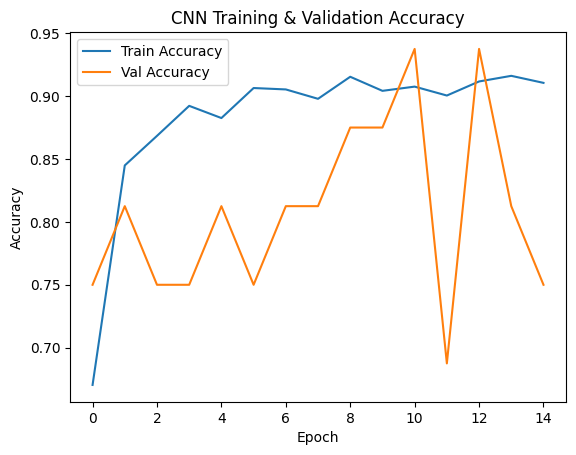

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training & Validation Accuracy')
plt.legend()
plt.show()


ResNet50

In [25]:
from tensorflow.keras.applications import ResNet50

In [26]:
# Load ResNet50 pretrained on ImageNet without top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze convolutional base

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 87s 976ms/step - accuracy: 0.5116 - loss: 0.7402 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 932ms/step - accuracy: 0.5246 - loss: 0.7109 - val_accuracy: 0.5000 - val_loss: 0.6862
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5477 - loss: 0.6863 - val_accuracy: 0.6250 - val_loss: 0.6691
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 882ms/step - accuracy: 0.6037 - loss: 0.6635 - val_accuracy: 0.6250 - val_loss: 0.6622
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 943ms/step - accuracy: 0.6495 - loss: 0.6475 - val_accuracy: 0.6250 - val_loss: 0.6528
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.6883 - loss: 0.6347 - val_accuracy: 0.7500 - val_loss: 0.6441
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 871ms/step - accuracy: 0.6939 - loss: 0.6216 - val_accuracy: 0.6250 - val_loss: 0.6393
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 905ms/step - accuracy: 0.7278 - loss: 0.6124 - val_accuracy:

In [28]:
# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)

# True labels
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA'])
print("Classification Report:\n", cr)

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 685ms/step - accuracy: 0.7863 - loss: 0.5595
Test Accuracy: 78.63%
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 747ms/step
Confusion Matrix:
 [[176  58]
 [ 42 192]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.81      0.75      0.78       234
   PNEUMONIA       0.77      0.82      0.79       234

    accuracy                           0.79       468
   macro avg       0.79      0.79      0.79       468
weighted avg       0.79      0.79      0.79       468

ROC-AUC: 0.8466


In [32]:
loss, acc = model.evaluate(train_gen)
print(f"Final training accuracy: {acc*100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 75s 884ms/step - accuracy: 0.9359 - loss: 0.1684
Final training accuracy: 93.59%


FINE TUNE ResNet

In [29]:
# Unfreeze last convolutional block
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compile with smaller LR
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again
history_ft = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8169 - loss: 0.4486 - val_accuracy: 0.5000 - val_loss: 0.9721
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8904 - loss: 0.2693 - val_accuracy: 0.6250 - val_loss: 0.6040
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9079 - loss: 0.2413 - val_accuracy: 0.5000 - val_loss: 0.8063
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9161 - loss: 0.2213 - val_accuracy: 0.5625 - val_loss: 1.5057
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9068 - loss: 0.2304 - val_accuracy: 0.6875 - val_loss: 0.6325
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9165 - loss: 0.2091 - val_accuracy: 0.5000 - val_loss: 1.9992
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9191 - loss: 0.2246 - val_accuracy: 0.7500 - val_loss: 0.4945
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9146 - loss: 0.2250 - val_accuracy: 0.5625 - v

In [30]:
# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)

# True labels
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA'])
print("Classification Report:\n", cr)

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 693ms/step - accuracy: 0.8226 - loss: 0.4153
Test Accuracy: 82.26%
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 764ms/step
Confusion Matrix:
 [[181  53]
 [ 30 204]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.86      0.77      0.81       234
   PNEUMONIA       0.79      0.87      0.83       234

    accuracy                           0.82       468
   macro avg       0.83      0.82      0.82       468
weighted avg       0.83      0.82      0.82       468

ROC-AUC: 0.9139


In [31]:
loss, acc = model.evaluate(train_gen)
print(f"Final training accuracy: {acc*100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 876ms/step - accuracy: 0.9448 - loss: 0.1539
Final training accuracy: 94.48%


USING THE MODEL OF CheXNet Model

CheXNet is essentially a DenseNet-121 model, pretrained on ImageNet, modified for binary classification, trained with Adam optimizer, learning rate decay on plateau, mini-batch size 16, and model selection based on lowest validation loss.

Data preperation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 16  # CheXNet uses 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "./DATASET/chest_xray_balanced/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    "./DATASET/chest_xray_balanced/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    "./DATASET/chest_xray_balanced/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 2682 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 468 images belonging to 2 classes.


BUILD CHEXNET MODEL

In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 without top
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze initially

# CheXNet-style head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 18s 1us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

TRAINING WITH CALLBACKS(LR Delay+Esrly Stopping)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Reduce learning rate when validation loss plateaus
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Early stopping to prevent overfitting and pick best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save best model
checkpoint = ModelCheckpoint("chexnet_best.h5", monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # can be higher; early stopping handles stopping
    callbacks=[lr_callback, early_stop, checkpoint]
)


Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7242 - loss: 0.5325

168/168 ━━━━━━━━━━━━━━━━━━━━ 94s 498ms/step - accuracy: 0.8087 - loss: 0.4164 - val_accuracy: 0.7500 - val_loss: 0.4159 - learning_rate: 1.0000e-04
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8896 - loss: 0.2941

168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 476ms/step - accuracy: 0.8956 - loss: 0.2789 - val_accuracy: 0.7500 - val_loss: 0.3709 - learning_rate: 1.0000e-04
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9223 - loss: 0.2202

168/168 ━━━━━━━━━━━━━━━━━━━━ 86s 512ms/step - accuracy: 0.9169 - loss: 0.2309 - val_accuracy: 0.8750 - val_loss: 0.3145 - learning_rate: 1.0000e-04
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 472ms/step - accuracy: 0.9150 - loss: 0.2267 - val_accuracy: 0.8125 - val_loss: 0.3256 - learning_rate: 1.0000e-04
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9260 - loss: 0.2151

168/168 ━━━━━━━━━━━━━━━━━━━━ 79s 466ms/step - accuracy: 0.9239 - loss: 0.2128 - val_accuracy: 0.8125 - val_loss: 0.3137 - learning_rate: 1.0000e-04
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9333 - loss: 0.2035

168/168 ━━━━━━━━━━━━━━━━━━━━ 100s 593ms/step - accuracy: 0.9258 - loss: 0.2047 - val_accuracy: 0.8750 - val_loss: 0.2832 - learning_rate: 1.0000e-04
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 92s 549ms/step - accuracy: 0.9239 - loss: 0.2011 - val_accuracy: 0.8125 - val_loss: 0.2945 - learning_rate: 1.0000e-04
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9451 - loss: 0.1802

168/168 ━━━━━━━━━━━━━━━━━━━━ 77s 455ms/step - accuracy: 0.9385 - loss: 0.1815 - val_accuracy: 0.8750 - val_loss: 0.2685 - learning_rate: 1.0000e-04
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9444 - loss: 0.1649

168/168 ━━━━━━━━━━━━━━━━━━━━ 75s 445ms/step - accuracy: 0.9359 - loss: 0.1812 - val_accuracy: 0.8750 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9456 - loss: 0.1651

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 453ms/step - accuracy: 0.9415 - loss: 0.1689 - val_accuracy: 0.9375 - val_loss: 0.2536 - learning_rate: 1.0000e-04
Epoch 11/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9447 - loss: 0.1565

168/168 ━━━━━━━━━━━━━━━━━━━━ 93s 553ms/step - accuracy: 0.9400 - loss: 0.1659 - val_accuracy: 0.8750 - val_loss: 0.2407 - learning_rate: 1.0000e-04
Epoch 12/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9479 - loss: 0.1554

168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.9400 - loss: 0.1714 - val_accuracy: 0.8750 - val_loss: 0.2405 - learning_rate: 1.0000e-04
Epoch 13/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9437 - loss: 0.1624 - val_accuracy: 0.8125 - val_loss: 0.2692 - learning_rate: 1.0000e-04
Epoch 14/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9392 - loss: 0.1648

168/168 ━━━━━━━━━━━━━━━━━━━━ 75s 445ms/step - accuracy: 0.9400 - loss: 0.1564 - val_accuracy: 0.8750 - val_loss: 0.2356 - learning_rate: 1.0000e-04
Epoch 15/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9388 - loss: 0.1568

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 451ms/step - accuracy: 0.9482 - loss: 0.1473 - val_accuracy: 0.9375 - val_loss: 0.2254 - learning_rate: 1.0000e-04
Epoch 16/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9435 - loss: 0.1495

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.9463 - loss: 0.1504 - val_accuracy: 0.8750 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 17/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9434 - loss: 0.1447

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 451ms/step - accuracy: 0.9459 - loss: 0.1425 - val_accuracy: 0.9375 - val_loss: 0.1963 - learning_rate: 1.0000e-04
Epoch 18/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9510 - loss: 0.1411

168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 476ms/step - accuracy: 0.9478 - loss: 0.1459 - val_accuracy: 0.9375 - val_loss: 0.1877 - learning_rate: 1.0000e-04
Epoch 19/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 77s 458ms/step - accuracy: 0.9448 - loss: 0.1482 - val_accuracy: 0.9375 - val_loss: 0.1954 - learning_rate: 1.0000e-04
Epoch 20/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 453ms/step - accuracy: 0.9482 - loss: 0.1447 - val_accuracy: 0.9375 - val_loss: 0.1893 - learning_rate: 1.0000e-04
Epoch 21/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9394 - loss: 0.1544
Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
168/168 ━━━━━━━━━━━━━━━━━━━━ 78s 463ms/step - accuracy: 0.9471 - loss: 0.1404 - val_accuracy: 0.8750 - val_loss: 0.1971 - learning_rate: 1.0000e-04
Epoch 22/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9524 - loss: 0.1424

168/168 ━━━━━━━━━━━━━━━━━━━━ 81s 484ms/step - accuracy: 0.9526 - loss: 0.1349 - val_accuracy: 0.9375 - val_loss: 0.1858 - learning_rate: 1.0000e-05
Epoch 23/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 448ms/step - accuracy: 0.9504 - loss: 0.1420 - val_accuracy: 0.9375 - val_loss: 0.1860 - learning_rate: 1.0000e-05
Epoch 24/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.9512 - loss: 0.1372 - val_accuracy: 0.9375 - val_loss: 0.1863 - learning_rate: 1.0000e-05
Epoch 25/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9453 - loss: 0.1429

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 452ms/step - accuracy: 0.9493 - loss: 0.1408 - val_accuracy: 0.9375 - val_loss: 0.1815 - learning_rate: 1.0000e-05
Epoch 26/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 77s 459ms/step - accuracy: 0.9504 - loss: 0.1351 - val_accuracy: 0.9375 - val_loss: 0.1823 - learning_rate: 1.0000e-05
Epoch 27/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.9489 - loss: 0.1319 - val_accuracy: 0.9375 - val_loss: 0.1829 - learning_rate: 1.0000e-05
Epoch 28/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9515 - loss: 0.1455

168/168 ━━━━━━━━━━━━━━━━━━━━ 81s 482ms/step - accuracy: 0.9523 - loss: 0.1376 - val_accuracy: 0.9375 - val_loss: 0.1803 - learning_rate: 1.0000e-05
Epoch 29/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9494 - loss: 0.1262

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.9504 - loss: 0.1313 - val_accuracy: 0.9375 - val_loss: 0.1801 - learning_rate: 1.0000e-05
Epoch 30/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9508 - loss: 0.1376 - val_accuracy: 0.9375 - val_loss: 0.1817 - learning_rate: 1.0000e-05
Epoch 31/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 74s 438ms/step - accuracy: 0.9523 - loss: 0.1351 - val_accuracy: 0.9375 - val_loss: 0.1820 - learning_rate: 1.0000e-05
Epoch 32/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9517 - loss: 0.1444
Epoch 32: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
168/168 ━━━━━━━━━━━━━━━━━━━━ 93s 555ms/step - accuracy: 0.9560 - loss: 0.1322 - val_accuracy: 0.9375 - val_loss: 0.1818 - learning_rate: 1.0000e-05
Epoch 33/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 605ms/step - accuracy: 0.9515 - loss: 0.1330 - val_accuracy: 0.9375 - val_loss: 0.1816 - learning_rate: 1.0000e-06
Epoch 34/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 604ms/step - 

FINETUNE DENSENET121 MODEL

In [12]:
# Unfreeze last DenseNet block
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compile with smaller LR
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[lr_callback, early_stop, checkpoint]
)


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 130s 642ms/step - accuracy: 0.8654 - loss: 0.3145 - val_accuracy: 0.8750 - val_loss: 0.1822 - learning_rate: 1.0000e-05
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9264 - loss: 0.1945

168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 598ms/step - accuracy: 0.9310 - loss: 0.1885 - val_accuracy: 1.0000 - val_loss: 0.1466 - learning_rate: 1.0000e-05
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9329 - loss: 0.1772

168/168 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9333 - loss: 0.1704 - val_accuracy: 1.0000 - val_loss: 0.1318 - learning_rate: 1.0000e-05
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9273 - loss: 0.1786

168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 599ms/step - accuracy: 0.9280 - loss: 0.1802 - val_accuracy: 1.0000 - val_loss: 0.1196 - learning_rate: 1.0000e-05
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9382 - loss: 0.1563

168/168 ━━━━━━━━━━━━━━━━━━━━ 101s 602ms/step - accuracy: 0.9385 - loss: 0.1607 - val_accuracy: 1.0000 - val_loss: 0.1107 - learning_rate: 1.0000e-05
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9514 - loss: 0.1458

168/168 ━━━━━━━━━━━━━━━━━━━━ 1155s 7s/step - accuracy: 0.9504 - loss: 0.1397 - val_accuracy: 1.0000 - val_loss: 0.0939 - learning_rate: 1.0000e-05
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9567 - loss: 0.1203

168/168 ━━━━━━━━━━━━━━━━━━━━ 77s 457ms/step - accuracy: 0.9493 - loss: 0.1378 - val_accuracy: 1.0000 - val_loss: 0.0898 - learning_rate: 1.0000e-05
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9374 - loss: 0.1798

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.9489 - loss: 0.1493 - val_accuracy: 1.0000 - val_loss: 0.0898 - learning_rate: 1.0000e-05
Epoch 9/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9529 - loss: 0.1456

168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 449ms/step - accuracy: 0.9538 - loss: 0.1314 - val_accuracy: 1.0000 - val_loss: 0.0882 - learning_rate: 1.0000e-05
Epoch 10/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9442 - loss: 0.1409

168/168 ━━━━━━━━━━━━━━━━━━━━ 78s 463ms/step - accuracy: 0.9463 - loss: 0.1374 - val_accuracy: 1.0000 - val_loss: 0.0805 - learning_rate: 1.0000e-05


EVALUATION

In [13]:
# Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

cr = classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA'])
print("Classification Report:\n", cr)

roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step - accuracy: 0.8932 - loss: 0.3183
Test Accuracy: 89.32%
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 463ms/step
Confusion Matrix:
 [[193  41]
 [  9 225]]
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.89       234
   PNEUMONIA       0.85      0.96      0.90       234

    accuracy                           0.89       468
   macro avg       0.90      0.89      0.89       468
weighted avg       0.90      0.89      0.89       468

ROC-AUC: 0.9607


GRAD-CAM VISUALIZATION

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [19]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name="conv5_block16_concat"):
    """
    Generate Grad-CAM heatmap for a given image and model.
    
    Args:
        model: Trained Keras model
        img_array: Preprocessed input image (1, H, W, 3)
        last_conv_layer_name: Name of the last conv layer in DenseNet121
    Returns:
        heatmap: Grad-CAM heatmap (H, W)
    """
    # Create a model that maps input to last conv layer and output
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # target class (pneumonia probability)
    
    # Compute gradients of target class w.r.t conv layer output
    grads = tape.gradient(loss, conv_outputs)
    
    # Global average pooling to get importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply conv outputs by importance weights
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # ReLU to keep positive influence
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path, target_size=(224,224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


In [18]:
def overlay_heatmap(img_path, heatmap, alpha=0.4, cmap='jet'):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Read original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # ✅ Scale to 0–255 and convert to uint8
    heatmap = np.uint8(255 * heatmap)

    # Apply color map
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on image
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    plt.show()


c:\Users\LOQ\Downloads\PNEUMONIA DETECTION\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1555']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


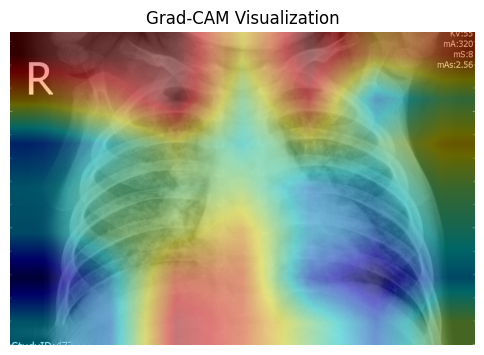

In [20]:
img_path = r"C:\Users\LOQ\Downloads\PNEUMONIA DETECTION\DATASET\chest_xray_balanced\test\PNEUMONIA\person1679_virus_2896.jpeg"
img_array = preprocess_image(img_path)

heatmap = get_gradcam_heatmap(model, img_array)
overlay_heatmap(img_path, heatmap)

TEST

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to test image
img_path = r"C:\Users\LOQ\Downloads\PNEUMONIA DETECTION\DATASET\chest_xray_balanced\test\PNEUMONIA\person1679_virus_2896.jpeg"

# Load and preprocess
img = image.load_img(img_path, target_size=(300, 300))  # match your training size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalization

# Predict
pred = model.predict(img_array)[0][0]

# Interpret
label = "PNEUMONIA" if pred > 0.5 else "NORMAL"

# Display
plt.imshow(img)
plt.title(f"Prediction: {label} ({pred:.2f})")
plt.axis("off")
plt.show()


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 300, 300, 3)